In [21]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [168]:
from glob import glob

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotx
import pandas as pd
from fastcore.xtras import load_pickle
from scipy.stats import sem

from gptchem.evaluator import find_learning_curve_intersection, fit_learning_curve, lc
from gptchem.plotsettings import *
from gptchem.settings import (
    ONE_COL_GOLDEN_RATIO_HEIGHT_INCH,
    ONE_COL_WIDTH_INCH,
    TWO_COL_GOLDEN_RATIO_HEIGHT_INCH,
)

%matplotlib inline

In [169]:
molclr = pd.read_csv("../molclr_classifcation_res.csv")
molclr["accuracy"] = molclr["acc"]
molclr_grouped = (
    molclr[molclr["name"] == "photoswitch"]
    .groupby(["classes", "num_size"])
    .agg(["mean", "std", sem])
)

In [170]:
molclr_grouped

Unnamed: 0                             acc            \
                        mean        std        sem      mean       std   
classes num_size                                                         
2       10         86.000000  62.241465  31.120733  0.595395  0.081150   
        20        149.000000  51.156622  29.535290  0.707207  0.086543   
        50         99.666667  58.071795  33.527766  0.844575  0.057765   
        100        46.333333  41.549168  23.988423  0.903299  0.009852   
        200       151.000000  60.008333  34.645827  0.913265  0.026997   
5       10        123.000000        NaN        NaN  0.728421       NaN   
        20        177.000000        NaN        NaN  0.732973       NaN   
        50         60.000000        NaN        NaN  0.778299       NaN   
        100        17.000000        NaN        NaN  0.814334       NaN   
        200        79.000000        NaN        NaN  0.873469       NaN   

                            f1_macro                      f1_micro            \
                       sem      mean       std       sem      mean       std   
classes num_size                                                               
2       10        0.040575  0.551879  0.124453  0.062227  0.595395  0.081150   
        20        0.049965  0.691179  0.104986  0.060614  0.707207  0.086543   
        50        0.033350  0.840854  0.063792  0.036830  0.844575  0.057765   
        100       0.005688  0.902912  0.009849  0.005686  0.903299  0.009852   
        200       0.015587  0.912860  0.027337  0.015783  0.913265  0.026997   
5       10             NaN  0.266735       NaN       NaN  0.321053       NaN   
        20             NaN  0.311711       NaN       NaN  0.332432       NaN   
        50             NaN  0.432113       NaN       NaN  0.445748       NaN   
        100            NaN  0.522816       NaN       NaN  0.535836       NaN   
        200            NaN  0.664566       NaN       NaN  0.683673       NaN   

                            accuracy                      
                       sem      mean       std       sem  
classes num_size                                          
2       10        0.040575  0.595395  0.081150  0.040575  
        20        0.049965  0.707207  0.086543  0.049965  
        50        0.033350  0.844575  0.057765  0.033350  
        100       0.005688  0.903299  0.009852  0.005688  
        200       0.015587  0.913265  0.026997  0.015587  
5       10             NaN  0.728421       NaN       NaN  
        20             NaN  0.732973       NaN       NaN  
        50             NaN  0.778299       NaN       NaN  
        100            NaN  0.814334       NaN       NaN  
        200            NaN  0.873469       NaN       NaN

In [171]:
gptj_results = pd.read_pickle("results_gptj.pkl")

### N-Gram baseline results


In [177]:
n_gram_baseline = glob("ngram_baseline/*.pkl")

In [178]:
n_gram_baseline_results = []

for f in n_gram_baseline:
    n_gram_baseline_results.append(load_pickle(f))

In [179]:
n_gram_baseline_results = pd.DataFrame(n_gram_baseline_results)

In [180]:
n_gram_baseline_results_grouped = (
    n_gram_baseline_results[
        ["num_classes", "representation", "train_size", "accuracy", "f1_micro", "f1_macro", "kappa"]
    ]
    .groupby(["num_classes", "representation", "train_size"])
    .agg(["mean", "std", sem])
)

In [181]:
n_gram_baseline_results_grouped

accuracy                      f1_micro  \
                                           mean       std       sem      mean   
num_classes representation train_size                                           
2           SMILES         10          0.630000  0.000000  0.000000  0.630000   
                           20          0.540000  0.000000  0.000000  0.540000   
                           50          0.690000  0.000000  0.000000  0.690000   
                           100         0.760000  0.000000  0.000000  0.760000   
                           200         0.810000  0.000000  0.000000  0.810000   
            inchi          10          0.627778  0.083333  0.027778  0.627778   
                           20          0.752000  0.031552  0.009978  0.752000   
                           50          0.790000  0.000000  0.000000  0.790000   
                           100         0.851111  0.003333  0.001111  0.851111   
                           200         0.834444  0.016667  0.005556  0.834444   
            name           10          0.756410  0.000000  0.000000  0.756410   
                           20          0.838235  0.000000  0.000000  0.838235   
                           50          0.868421  0.000000  0.000000  0.868421   
            selfies        10          0.540000  0.000000  0.000000  0.540000   
                           20          0.620000  0.000000  0.000000  0.620000   
                           50          0.443333  0.070000  0.023333  0.443333   
                           100         0.570000  0.000000  0.000000  0.570000   
                           200         0.520000  0.000000  0.000000  0.520000   
5           SMILES         10          0.307000  0.054985  0.017388  0.307000   
                           20          0.321111  0.003333  0.001111  0.321111   
                           50          0.398000  0.031552  0.009978  0.398000   
                           100         0.381111  0.003333  0.001111  0.381111   
                           200         0.410000  0.000000  0.000000  0.410000   
            inchi          10          0.460000  0.000000  0.000000  0.460000   
                           20          0.420000  0.000000  0.000000  0.420000   
                           50          0.516667  0.040000  0.013333  0.516667   
                           100         0.350000  0.000000  0.000000  0.350000   
                           200         0.380000  0.000000  0.000000  0.380000   
            name           10          0.330484  0.008547  0.002849  0.330484   
                           20          0.397059  0.000000  0.000000  0.397059   
                           50          0.421053  0.000000  0.000000  0.421053   
            selfies        10          0.310000  0.000000  0.000000  0.310000   
                           20          0.240000  0.000000  0.000000  0.240000   
                           50          0.292222  0.023333  0.007778  0.292222   
                           100         0.356667  0.010000  0.003333  0.356667   
                           200         0.374000  0.018974  0.006000  0.374000   

                                                           f1_macro            \
                                            std       sem      mean       std   
num_classes representation train_size                                           
2           SMILES         10          0.000000  0.000000  0.609334  0.000000   
                           20          0.000000  0.000000  0.452381  0.000000   
                           50          0.000000  0.000000  0.669333  0.000000   
                           100         0.000000  0.000000  0.756494  0.000000   
                           200         0.000000  0.000000  0.808448  0.000000   
            inchi          10          0.083333  0.027778  0.627193  0.083502   
                           20          0.031552  0.009978  0.751936  0.031462   
                           50          0.000000  0.000000  0.787781  

## Load results


In [182]:
all_out = glob("out/**/*.pkl")

In [183]:
all_out = [load_pickle(p) for p in all_out]

In [184]:
extracted_res = []
xgboost_results = []
tabpfn_results = []

for out in all_out:
    try:
        res = {
            "train_size": out["train_size"],
            "frac_valid": out["frac_valid"],
            "accuracy": out["accuracy"],
            "f1_macro": out["f1_macro"],
            "f1_micro": out["f1_micro"],
            "kappa": out["kappa"],
            "num_classes": out["num_classes"],
            "representation": out["representation"],
        }
        extracted_res.append(res)
    except KeyError:
        pass

    xgb_res = {
        "train_size": out["train_size"],
        "accuracy": out["xgboost_baseline"]["accuracy"],
        "f1_macro": out["xgboost_baseline"]["f1_macro"],
        "f1_micro": out["xgboost_baseline"]["f1_micro"],
        "kappa": out["xgboost_baseline"]["kappa"],
        "num_classes": out["num_classes"],
    }

    tabpfn_res = {
        "train_size": out["train_size"],
        "accuracy": out["tabpfn_baseline"]["accuracy"],
        "f1_macro": out["tabpfn_baseline"]["f1_macro"],
        "f1_micro": out["tabpfn_baseline"]["f1_micro"],
        "kappa": out["tabpfn_baseline"]["kappa"],
        "num_classes": out["num_classes"],
    }

    xgboost_results.append(xgb_res)
    tabpfn_results.append(tabpfn_res)

In [185]:
res = pd.DataFrame(extracted_res)
xgboost_res = pd.DataFrame(xgboost_results)
tabpfn_res = pd.DataFrame(tabpfn_results)

In [186]:
grouped_res = res.groupby(["num_classes", "representation", "train_size"]).agg(["mean", "std", sem])

In [187]:
grouped_xgboost_res = xgboost_res.groupby(["num_classes", "train_size"]).agg(["mean", "std", sem])

In [188]:
grouped_xgboost_res.to_pickle("xgboost_results.pkl")

In [189]:
grouped_tabpfn_res = tabpfn_res.groupby(["num_classes", "train_size"]).agg(["mean", "std", sem])

In [190]:
grouped_tabpfn_res.to_pickle("tabpfn_results.pkl")

In [191]:
grouped_res.loc[2, :]

frac_valid            accuracy                      \
                                mean  std  sem      mean       std       sem   
representation train_size                                                      
SMILES         10                1.0  0.0  0.0  0.663077  0.056772  0.015746   
               20                1.0  0.0  0.0  0.738182  0.065699  0.019809   
               50                1.0  0.0  0.0  0.809167  0.044202  0.012760   
               100               1.0  0.0  0.0  0.860909  0.027370  0.008252   
               200               1.0  0.0  0.0  0.872500  0.033063  0.009545   
inchi          10                1.0  0.0  0.0  0.580000  0.084656  0.023479   
               20                1.0  0.0  0.0  0.790000  0.033466  0.010090   
               50                1.0  0.0  0.0  0.817273  0.023277  0.007018   
               100               1.0  0.0  0.0  0.835455  0.042039  0.012675   
               200               1.0  0.0  0.0  0.856364  0.035291  0.010641   
name           10                1.0  0.0  0.0  0.749663  0.103054  0.018218   
               20                1.0  0.0  0.0  0.837010  0.045417  0.013111   
               50                1.0  0.0  0.0  0.858726  0.044909  0.010303   
selfies        10                1.0  0.0  0.0  0.590769  0.074214  0.020583   
               20                1.0  0.0  0.0  0.700000  0.077589  0.023394   
               50                1.0  0.0  0.0  0.766000  0.040879  0.012927   
               100               1.0  0.0  0.0  0.831818  0.037099  0.011186   
               200               1.0  0.0  0.0  0.847000  0.053344  0.016869   

                           f1_macro                      f1_micro            \
                               mean       std       sem      mean       std   
representation train_size                                                     
SMILES         10          0.641876  0.077671  0.021542  0.663077  0.056772   
               20          0.730227  0.073320  0.022107  0.738182  0.065699   
               50          0.808074  0.045029  0.012999  0.809167  0.044202   
               100         0.860459  0.027379  0.008255  0.860909  0.027370   
               200         0.872218  0.033372  0.009634  0.872500  0.033063   
inchi          10          0.528971  0.132754  0.036819  0.580000  0.084656   
               20          0.786820  0.034876  0.010516  0.790000  0.033466   
               50          0.816229  0.023690  0.007143  0.817273  0.023277   
               100         0.834967  0.042151  0.012709  0.835455  0.042039   
               200         0.856221  0.035327  0.010652  0.856364  0.035291   
name           10          0.735287  0.134059  0.023699  0.749663  0.103054   
               20          0.835383  0.046279  0.013360  0.837010  0.045417   
               50          0.857592  0.045555  0.010451  0.858726  0.044909   
selfies        10          0.555032  0.106606  0.029567  0.590769  0.074214   
               20          0.689477  0.091349  0.027543  0.700000  0.077589   
               50          0.764209  0.042167  0.013334  0.766000  0.040879   
               100         0.831324  0.037086  0.011182  0.831818  0.037099   
               200         0.846642  0.053471  0.016909  0.847000  0.053344   

                                        kappa                      
                                sem      mean       std       sem  
representation train_size                                          
SMILES         10          0.015746  0.326154  0.113544  0.031492  
               20          0.019809  0.476364  0.131398  0.039618  
               50          0.012760  0.618333  0.088403  0.025520  
               100         0.008252  0.721818  0.054739  0.016504  
               200         0.009545  0.745000  0.066127  0.019089  
inchi          10          0.023479  0.160000  0.169312  0.046959  
               20          0.010090  0.580000  0.066933  0.020181  
     

In [192]:
colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]

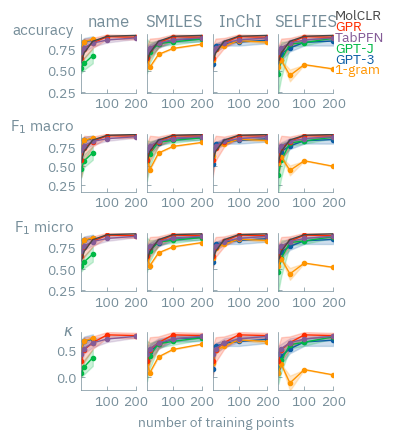

In [194]:
# with plt.style.context(matplotx.styles.dufte):
fig, ax = plt.subplots(
    4, 4, figsize=(ONE_COL_WIDTH_INCH, TWO_COL_GOLDEN_RATIO_HEIGHT_INCH), sharey="row"
)

# plot the binary case, i.e. num_classes = 2

for i, metric in enumerate(["accuracy", "f1_macro", "f1_micro", "kappa"]):
    for j, representation in enumerate(
        [
            "name",
            "SMILES",
            "inchi",
            "selfies",
        ]
    ):
        ax[i][j].plot(
            grouped_res.loc[2, representation][metric]["mean"].index,
            grouped_res.loc[2, representation][metric]["mean"],
            label="GPT-3",
            color=colors[0],
            marker="o",
        )
        ax[i][j].fill_between(
            grouped_res.loc[2, representation][metric]["mean"].index,
            grouped_res.loc[2, representation][metric]["mean"]
            - grouped_res.loc[2, representation][metric]["std"],
            grouped_res.loc[2, representation][metric]["mean"]
            + grouped_res.loc[2, representation][metric]["std"],
            alpha=0.2,
            color=colors[0],
        )

        if representation != "inchi":
            ax[i][j].plot(
                gptj_results.loc[representation][metric]["mean"].index,
                gptj_results.loc[representation][metric]["mean"],
                label="GPT-J",
                color=colors[1],
                marker="o",
            )
            ax[i][j].fill_between(
                gptj_results.loc[representation][metric]["mean"].index,
                gptj_results.loc[representation][metric]["mean"]
                - gptj_results.loc[representation][metric]["std"],
                gptj_results.loc[representation][metric]["mean"]
                + gptj_results.loc[representation][metric]["std"],
                alpha=0.2,
                color=colors[1],
            )

        ax[i][j].plot(
            n_gram_baseline_results_grouped.loc[2, representation][metric]["mean"].index,
            n_gram_baseline_results_grouped.loc[2, representation][metric]["mean"],
            label="1-gram",
            color=colors[2],
            marker="o",
        )
        ax[i][j].fill_between(
            n_gram_baseline_results_grouped.loc[2, representation][metric]["mean"].index,
            n_gram_baseline_results_grouped.loc[2, representation][metric]["mean"]
            - n_gram_baseline_results_grouped.loc[2, representation][metric]["std"],
            n_gram_baseline_results_grouped.loc[2, representation][metric]["mean"]
            + n_gram_baseline_results_grouped.loc[2, representation][metric]["std"],
            alpha=0.2,
            color=colors[2],
        )

        ax[i][j].plot(
            grouped_xgboost_res.loc[2][metric]["mean"].index,
            grouped_xgboost_res.loc[2][metric]["mean"],
            label="GPR",
            color=colors[3],
            marker="o",
        )
        ax[i][j].fill_between(
            grouped_xgboost_res.loc[2][metric]["mean"].index,
            grouped_xgboost_res.loc[2][metric]["mean"] - grouped_xgboost_res.loc[2][metric]["std"],
            grouped_xgboost_res.loc[2][metric]["mean"] + grouped_xgboost_res.loc[2][metric]["std"],
            alpha=0.2,
            color=colors[3],
        )

        ax[i][j].plot(
            grouped_tabpfn_res.loc[2][metric]["mean"].index,
            grouped_tabpfn_res.loc[2][metric]["mean"],
            label="TabPFN",
            color=colors[4],
            marker="o",
        )
        ax[i][j].fill_between(
            grouped_tabpfn_res.loc[2][metric]["mean"].index,
            grouped_tabpfn_res.loc[2][metric]["mean"] - grouped_tabpfn_res.loc[2][metric]["std"],
            grouped_tabpfn_res.loc[2][metric]["mean"] + grouped_tabpfn_res.loc[2][metric]["std"],
            alpha=0.2,
            color=colors[4],
        )

        if metric != "kappa":
            ax[i][j].plot(
                molclr_grouped.loc[2][metric]["mean"].index,
                molclr_grouped.loc[2][metric]["mean"],
                label="MolCLR",
                color=colors[5],
            )


matplotx.line_labels(ax[0][3])
ylabel_top("accuracy", ax=ax[0][0], y_pad=0.1, x_pad=0.04)
ylabel_top(r"F$_{1}$ macro", ax=ax[1][0], y_pad=0.1, x_pad=0.04)
ylabel_top(r"F$_{1}$ micro", ax=ax[2][0], y_pad=0.1, x_pad=0.04)
ylabel_top(r"$\kappa$", ax=ax[3][0], y_pad=0.1, x_pad=0.04)
# plt.subplots_adjust(hspace=0.6, top=1, bottom=0.2)
# ax[-1][1].set_xlabel("number of training points", labelpad=4)

# label x axis once for all columns in the middle of the columns in the last row
fig.text(0.3, 0.12, "number of training points")

for i, col in enumerate(["name", "SMILES", "InChI", "SELFIES"]):
    ax[0][i].set_title(col)

plt.subplots_adjust(hspace=0.7, top=1, bottom=0.2)

fig.savefig("photoswitch-classification_results_binary.pdf", bbox_inches="tight")

In [195]:
intersections = []

for i, val in enumerate(grouped_res.loc[2, "name", :].index):
    factor = (
        find_learning_curve_intersection(
            grouped_res.loc[2, "name", :]["f1_macro"]["mean"].values[i],
            fit_learning_curve(
                grouped_xgboost_res.loc[2, :].index,
                grouped_xgboost_res.loc[2, :]["f1_macro"]["mean"],
            )[0],
        )
        / val
    )

    intersections.append(factor)

In [196]:
intersections_tabpfn = []

for i, val in enumerate(grouped_res.loc[2, "name", :].index):
    factor = (
        find_learning_curve_intersection(
            grouped_res.loc[2, "name", :]["f1_macro"]["mean"].values[i],
            fit_learning_curve(
                grouped_tabpfn_res.loc[2, :].index,
                grouped_tabpfn_res.loc[2, :]["f1_macro"]["mean"],
            )[0],
        )
        / val
    )

    intersections_tabpfn.append(factor)

In [197]:
intersections_molclr = []

for i, val in enumerate(grouped_res.loc[2, "name", :].index):
    factor = (
        find_learning_curve_intersection(
            grouped_res.loc[2, "name", :]["f1_macro"]["mean"].values[i],
            fit_learning_curve(
                molclr_grouped.loc[2, :].index,
                molclr_grouped.loc[2, :]["f1_macro"]["mean"],
            )[0],
        )
        / val
    )

    intersections_molclr.append(factor)

In [198]:
intersections_molclr

[2.0479965063380905, 1.6548563173755302, 0.7943667601727006]

In [199]:
from gptchem.evaluator import add_kappa_vlines, get_kappa_intersections

In [200]:
get_kappa_intersections(
    grouped_res.loc[2, "SMILES", :].index.values,
    grouped_res.loc[2, "SMILES", :]["kappa"]["mean"].values,
)

{0: -0.3325822597631418,
 0.2: 5.862727053231399,
 0.4: 15.116261465167705,
 0.6: 33.883297895010294,
 0.8: 654.4947285329912}

In [201]:
intersections

[1.8402804598428357, 1.591498492257191, 0.8388911549969247]

In [202]:
intersections_tabpfn

[1.1932441971579721, 1.3361931173137873, 3.7570624332327673]

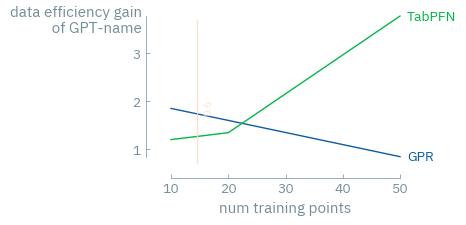

In [203]:
# with plt.style.context(matplotx.styles.dufte):
fig, ax = plt.subplots(1, 1, figsize=(ONE_COL_WIDTH_INCH, ONE_COL_GOLDEN_RATIO_HEIGHT_INCH))
ax.plot(grouped_res.loc[2, "name", :].index, intersections, label="GPR")
ax.plot(grouped_res.loc[2, "name", :].index, intersections_tabpfn, label="TabPFN")
matplotx.line_labels()

ylabel_top("data efficiency gain\n of GPT-name", x_pad=0.05, y_pad=-0.01)
plt.xlabel("num training points", labelpad=4)

add_kappa_vlines(
    grouped_res.loc[2, "name", :].index.values,
    grouped_res.loc[2, "name", :]["kappa"]["mean"].values,
    ymax=3.7,
)

range_frame(
    ax,
    grouped_res.loc[2, "name", :].index.values,
    np.stack([intersections, intersections_tabpfn]).flatten(),
    0.05,
)
plt.savefig("photoswitch-binary-data-efficiency.pdf", bbox_inches="tight")

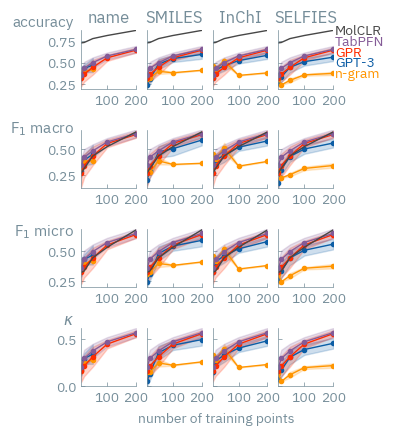

In [204]:
fig, ax = plt.subplots(
    4, 4, figsize=(ONE_COL_WIDTH_INCH, TWO_COL_GOLDEN_RATIO_HEIGHT_INCH), sharey="row"
)

# plot the binary case, i.e. num_classes = 2

for i, metric in enumerate(["accuracy", "f1_macro", "f1_micro", "kappa"]):
    for j, representation in enumerate(
        [
            "name",
            "SMILES",
            "inchi",
            "selfies",
        ]
    ):
        ax[i][j].plot(
            grouped_res.loc[5, representation][metric]["mean"].index,
            grouped_res.loc[5, representation][metric]["mean"],
            label="GPT-3",
            color=colors[0],
            marker="o",
        )
        ax[i][j].fill_between(
            grouped_res.loc[5, representation][metric]["mean"].index,
            grouped_res.loc[5, representation][metric]["mean"]
            - grouped_res.loc[5, representation][metric]["std"],
            grouped_res.loc[5, representation][metric]["mean"]
            + grouped_res.loc[5, representation][metric]["std"],
            alpha=0.2,
            color=colors[0],
        )

        # if representation != 'inchi':
        #     ax[i][j].plot(
        #         gptj_results.loc[representation][metric]["mean"].index,
        #         gptj_results.loc[representation][metric]["mean"],
        #         label="GPT-J",
        #         color = colors[1],
        #                   marker = 'o'

        #     )
        #     ax[i][j].fill_between(
        #         gptj_results.loc[representation][metric]["mean"].index,
        #         gptj_results.loc[representation][metric]["mean"]
        #         - gptj_results.loc[representation][metric]["std"],
        #         gptj_results.loc[representation][metric]["mean"]
        #         + gptj_results.loc[representation][metric]["std"],
        #         alpha=0.2,
        #         color = colors[1]
        #     )

        ax[i][j].plot(
            n_gram_baseline_results_grouped.loc[5, representation][metric]["mean"].index,
            n_gram_baseline_results_grouped.loc[5, representation][metric]["mean"],
            label="n-gram",
            color=colors[2],
            marker="o",
        )
        ax[i][j].fill_between(
            n_gram_baseline_results_grouped.loc[5, representation][metric]["mean"].index,
            n_gram_baseline_results_grouped.loc[5, representation][metric]["mean"]
            - n_gram_baseline_results_grouped.loc[5, representation][metric]["std"],
            n_gram_baseline_results_grouped.loc[5, representation][metric]["mean"]
            + n_gram_baseline_results_grouped.loc[5, representation][metric]["std"],
            alpha=0.2,
            color=colors[2],
        )

        ax[i][j].plot(
            grouped_xgboost_res.loc[5][metric]["mean"].index,
            grouped_xgboost_res.loc[5][metric]["mean"],
            label="GPR",
            color=colors[3],
            marker="o",
        )
        ax[i][j].fill_between(
            grouped_xgboost_res.loc[5][metric]["mean"].index,
            grouped_xgboost_res.loc[5][metric]["mean"] - grouped_xgboost_res.loc[5][metric]["std"],
            grouped_xgboost_res.loc[5][metric]["mean"] + grouped_xgboost_res.loc[5][metric]["std"],
            alpha=0.2,
            color=colors[3],
        )

        ax[i][j].plot(
            grouped_tabpfn_res.loc[5][metric]["mean"].index,
            grouped_tabpfn_res.loc[5][metric]["mean"],
            label="TabPFN",
            color=colors[4],
            marker="o",
        )
        ax[i][j].fill_between(
            grouped_tabpfn_res.loc[5][metric]["mean"].index,
            grouped_tabpfn_res.loc[5][metric]["mean"] - grouped_tabpfn_res.loc[5][metric]["std"],
            grouped_tabpfn_res.loc[5][metric]["mean"] + grouped_tabpfn_res.loc[5][metric]["std"],
            alpha=0.2,
            color=colors[4],
        )

        if metric != "kappa":
            ax[i][j].plot(
                molclr_grouped.loc[5][metric]["mean"].index,
                molclr_grouped.loc[5][metric]["mean"],
                label="MolCLR",
                color=colors[5],
            )


matplotx.line_labels(ax[0][3])
ylabel_top("accuracy", ax=ax[0][0], y_pad=0.1, x_pad=0.04)
ylabel_top(r"F$_{1}$ macro", ax=ax[1][0], y_pad=0.1, x_pad=0.04)
ylabel_top(r"F$_{1}$ micro", ax=ax[2][0], y_pad=0.1, x_pad=0.04)
ylabel_top(r"$\kappa$", ax=ax[3][0], y_pad=0.1, x_pad=0.04)
# plt.subplots_adjust(hspace=0.6, top=1, bottom=0.2)
# ax[-1][1].set_xlabel("number of training points", labelpad=4)

# label x axis once for all columns in the middle of the columns in the last row
fig.text(0.3, 0.12, "number of training points")

for i, col in enumerate(["name", "SMILES", "InChI", "SELFIES"]):
    ax[0][i].set_title(col)

plt.subplots_adjust(hspace=0.7, top=1, bottom=0.2)

fig.savefig("photoswitch-classification_results_5_class.pdf", bbox_inches="tight")

In [205]:
intersections = []

for i, val in enumerate(grouped_res.loc[5, "name", :].index):
    factor = (
        find_learning_curve_intersection(
            grouped_res.loc[5, "name", :]["f1_macro"]["mean"].values[i],
            fit_learning_curve(
                grouped_xgboost_res.loc[5, :].index,
                grouped_xgboost_res.loc[5, :]["f1_macro"]["mean"],
            )[0],
        )
        / val
    )

    intersections.append(factor)


intersections_tabpfn = []

for i, val in enumerate(grouped_res.loc[5, "name", :].index):
    factor = (
        find_learning_curve_intersection(
            grouped_res.loc[5, "name", :]["f1_macro"]["mean"].values[i],
            fit_learning_curve(
                grouped_tabpfn_res.loc[5, :].index,
                grouped_tabpfn_res.loc[5, :]["f1_macro"]["mean"],
            )[0],
        )
        / val
    )

    intersections_tabpfn.append(factor)

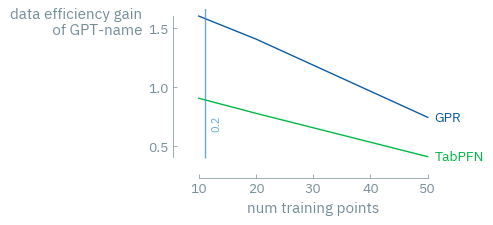

In [206]:
fig, ax = plt.subplots(1, 1, figsize=(ONE_COL_WIDTH_INCH, ONE_COL_GOLDEN_RATIO_HEIGHT_INCH))

ax.plot(grouped_res.loc[2, "name", :].index, intersections, label="GPR")
ax.plot(grouped_res.loc[2, "name", :].index, intersections_tabpfn, label="TabPFN")
matplotx.line_labels()

ylabel_top("data efficiency gain\n  of GPT-name", y_pad=-0.2, x_pad=0.16)
plt.xlabel("num training points", labelpad=4)

add_kappa_vlines(
    grouped_res.loc[5, "name", :].index.values,
    grouped_res.loc[5, "name", :]["kappa"]["mean"].values,
    ymin=0.4,
    ymax=1.7,
)

range_frame(
    ax,
    grouped_res.loc[5, "name", :].index.values,
    np.stack([intersections, intersections_tabpfn]).flatten(),
    0.05,
)

plt.savefig("photoswitch-5-data-efficiency.pdf", bbox_inches="tight")